In [2]:
# Item based collaborative filtering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.model_selection import KFold
import pickle

In [4]:
# Read the data
data = pd.read_csv('ratings_small.csv')

In [5]:
# Mean squared difference function
def msd(x, y):
    return np.mean((x - y)**2)

# Cosine similarity function
def cosine(x, y):
    denominator = np.linalg.norm(x) * np.linalg.norm(y)
    if denominator == 0:
        return 0
    return np.dot(x, y) / denominator

# Pearson correlation function
def pearson_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x = x - x_mean
    y = y - y_mean
    denominator = np.linalg.norm(x) * np.linalg.norm(y)
    if denominator == 0:
        return 0
    return np.dot(x, y) / denominator

In [6]:
# Compute the similarity matrix
def compute_similarity_matrix(data, similarity_function):
    # Create a matrix with the same size as the data
    similarity_matrix = np.zeros((data.shape[0], data.shape[0]))

    # similarity store
    similarity_store = {}

    for i in tqdm(range(data.shape[0])):
        for j in range(data.shape[0]):
            if (i,j) in similarity_store:
                similarity_matrix[i, j] = similarity_store[(i,j)]
            elif (j,i) in similarity_store:
                similarity_matrix[i, j] = similarity_store[(j,i)]
            else:
                # Compute the similarity
                similarity_matrix[i, j] = similarity_function(data[i, :], data[j, :])
                similarity_store[(i,j)] = similarity_matrix[i, j]
            
    return similarity_matrix

In [7]:
def item_collaborative_filtering(neighbours, movie_similarities, test_dataset, user_item_data):
    predictions = []
    actual = []
    for row in test_dataset.iterrows():
        # Get the user id and movie id
        user_id = int(row[1]['userId'])
        movie_id = int(row[1]['movieId'])

        # Get the movie index
        movie_index = user_item_data.index.get_loc(movie_id)

        # Get the user index

        try:
            user_index = user_item_data.columns.get_loc(user_id)
        except:
            predictions.append(0)
            actual.append(row[1]['rating'])
            continue

        # Get the movie similarity
        movie_similarity = movie_similarities[movie_index, :]

        # Get the known ratings
        known_ratings = user_item_data.values[:, user_index]

        # Get the top k neighbours
        top_k_neighbours = np.argsort(movie_similarity)[-(neighbours+1):]

        # exclude the movie itself
        top_k_neighbours = top_k_neighbours[top_k_neighbours != movie_index]

        # Get the top k similarity
        top_k_similarity = movie_similarity[top_k_neighbours]

        # Get the top k ratings
        top_k_ratings = known_ratings[top_k_neighbours]

        # Get the predicted rating
        prediction = np.sum(top_k_similarity * top_k_ratings) / np.sum(np.abs(top_k_similarity))

        # Append the prediction and actual
        predictions.append(prediction)
        actual.append(row[1]['rating'])
    
    return actual, predictions

In [8]:
# RMSE
def rmse(actual, predictions):
    return sqrt(mean_squared_error(actual, predictions))

# MAE
def mae(actual, predictions):
    return mean_absolute_error(actual, predictions)

In [9]:
data_splits = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# Create a pivot table
user_item_data = data.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [ ]:
# Calculate the cosine similarity
cosine_similarity = compute_similarity_matrix(user_item_data.values, cosine)

# Calculate the pearson correlation
pearson_similarity = compute_similarity_matrix(user_item_data.values, pearson_correlation)

# Calculate the msd
msd_similarity = compute_similarity_matrix(user_item_data.values, msd)

100%|██████████| 9066/9066 [14:44<00:00, 10.25it/s]


In [13]:
# 5 fold cross validation for cosine similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(10, cosine_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:55, 11.19s/it]



RMSE:  [2.164217527086999, 2.170070281726278, 2.162680516039309, 2.1553806867094436, 2.157794426607065]
Average RMSE:  2.162028687633819
MAE:  [1.8072340854355777, 1.8154017721772902, 1.801322610608136, 1.8028388250127116, 1.798433683762543]
Average MAE:  1.8050461953992518


In [14]:
# 5 fold cross validation for pearson similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(10, pearson_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [01:15, 15.09s/it]



RMSE:  [2.287432098454437, 2.2971909162294675, 2.289509750423417, 2.2820662472814934, 2.2830480517513787]
Average RMSE:  2.287849412828039
MAE:  [1.9466892452745859, 1.9597581009407525, 1.94530371185581, 1.944566466304632, 1.939895409514854]
Average MAE:  1.947242586778127


In [15]:
# 5 fold cross validation for msd similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(10, msd_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [01:09, 13.91s/it]



RMSE:  [2.058456160976849, 2.048987183262602, 2.0501454623117588, 2.042467537074433, 2.043562335059493]
Average RMSE:  2.048723735737027
MAE:  [1.6456935949272467, 1.6356884497783053, 1.643453611591157, 1.6274367276484398, 1.6284198609293616]
Average MAE:  1.636138448974902


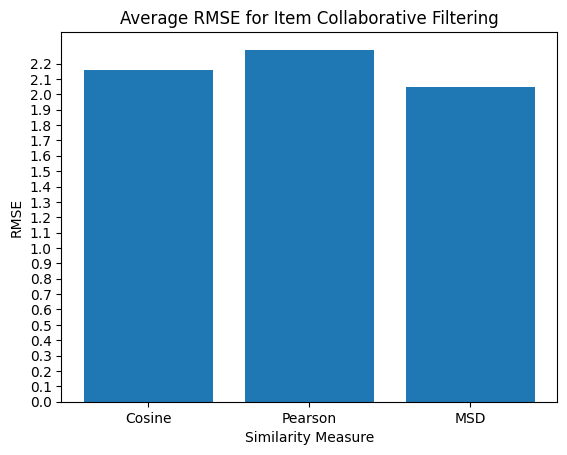

In [3]:
cosine_avg_rmse = 2.16
pearson_avg_rmse = 2.29
msd_avg_rmse = 2.05

plt.bar(['Cosine', 'Pearson', 'MSD'], [cosine_avg_rmse, pearson_avg_rmse, msd_avg_rmse])
plt.title('Average RMSE for Item Collaborative Filtering')
plt.xlabel('Similarity Measure')
plt.ylabel('RMSE')
plt.yticks(np.arange(0, 2.3, step=0.1))
plt.show()

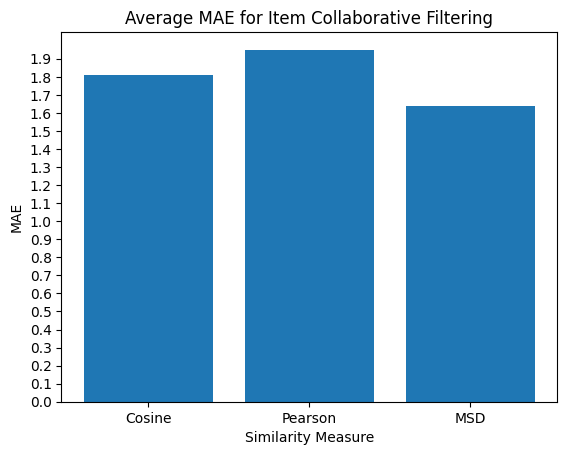

In [4]:
cosine_avg_mae = 1.81
pearson_avg_mae = 1.95
msd_avg_mae = 1.64

plt.bar(['Cosine', 'Pearson', 'MSD'], [cosine_avg_mae, pearson_avg_mae, msd_avg_mae])
plt.title('Average MAE for Item Collaborative Filtering')
plt.xlabel('Similarity Measure')
plt.ylabel('MAE')
plt.yticks(np.arange(0, 2, step=0.1))
plt.show()

In [12]:
# Split the data into train and test
_, test = train_test_split(data, test_size=0.2, random_state=42)

100%|██████████| 18/18 [03:51<00:00, 12.85s/it]


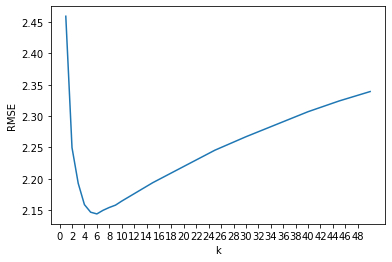

In [ ]:
# find the best k and plot rmse against k for cosine similarity
k_values = [1,2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_values = []

for k in tqdm(k_values):

    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(k, cosine_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_values.append(rmse(actual, predictions))

# Plot the rmse against k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 50, step=2))
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|██████████| 18/18 [05:00<00:00, 16.70s/it]


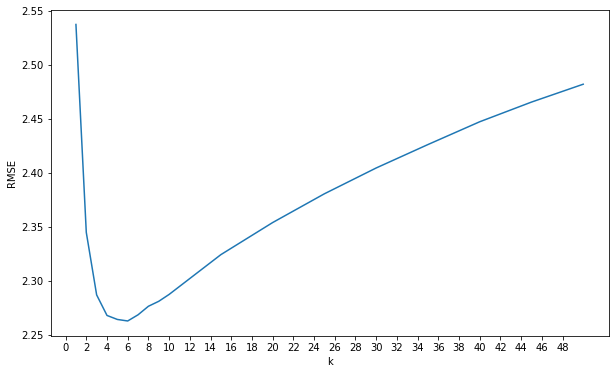

In [ ]:
# find the best k and plot rmse against k for pearson correlation
k_values = [1,2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_values = []

for k in tqdm(k_values):

    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(k, pearson_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_values.append(rmse(actual, predictions))

# Plot the rmse against k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 50, step=2))
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|██████████| 18/18 [04:39<00:00, 15.52s/it]


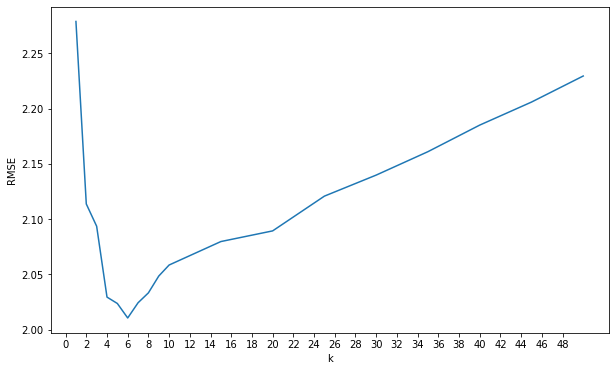

In [ ]:
# find the best k and plot rmse against k for msd
k_values = [1,2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_values = []

for k in tqdm(k_values):

    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(k, msd_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_values.append(rmse(actual, predictions))

# Plot the rmse against k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 50, step=2))
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [ ]:
# 5 fold cross validation for cosine similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(6, cosine_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [01:03, 12.62s/it]



RMSE:  [2.143788025755459, 2.15145658088995, 2.144375017193516, 2.1344505137356053, 2.1378695981100253]
Average RMSE:  2.1423879471369114
MAE:  [1.7629286942770017, 1.7717157659977432, 1.7590867196421953, 1.7560551988377784, 1.7540011006574416]
Average MAE:  1.760757495882432


In [ ]:
# 5 fold cross validation for pearson similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(6, pearson_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [01:26, 17.32s/it]



RMSE:  [2.262853955819475, 2.268442734881938, 2.2641786432192927, 2.2556221177102382, 2.2554289673700207]
Average RMSE:  2.2613052838001932
MAE:  [1.8938858665563076, 1.9030271316020115, 1.8952720443530628, 1.889599701366485, 1.8851014974419464]
Average MAE:  1.8933772482639626


In [ ]:
# 5 fold cross validation for msd similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = item_collaborative_filtering(6, msd_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [01:15, 15.11s/it]



RMSE:  [2.0105199999365255, 1.9970478480015261, 1.9991519506504445, 1.9886288829009426, 1.9935949373458062]
Average RMSE:  1.9977887237670493
MAE:  [1.5796795077369026, 1.5634408988820325, 1.5772348864422479, 1.5562764571546746, 1.5618327027525316]
Average MAE:  1.5676928905936778
